In [28]:
import collections
#R.<r,p> = QQ[]
r,p = var("r,p")

In [27]:
def my_vandermonde(v, ncols=None, ring=None):
    def entries(i, j):
        return v[i]**j
    if ncols is None:
        ncols = len(v)
    return matrix(entries, nrows=len(v), ncols=ncols, ring=ring)

In [45]:

class Rule(object):
    def __init__(self, G):
        self._G = G
        self._states = None
        
    def _posibleStates(self):
        bini = lambda x : tuple( [(x >> i) & 1 for i in range(self._G.order())] )

        P = self._G.automorphism_group()

        states = {bini(u):None for u in range((1<<self._G.order())+1)}

        numStates = 0
        reducedStates = {}
        for u, val in states.items():
            if val is None: # Not found early
                reducedStates[u] = numStates
                numStates += 1
                for p in P:
                    newu = tuple( u[p(i)] for i in range(self._G.order()) )
                    states[newu] = u

        return states, reducedStates
    
    def _system_matrix(self, states, rule):
        P = {}
        # Moran rule
        remaining_states = [ states[ 
                                    (0,) * i +
                                    (1,) + 
                                    (0,) * (self._G.order()-i-1)
                                   ] for i in range(self._G.order())]
        self._wSs = {}
        while remaining_states:
            S = remaining_states.pop()
            if S not in P:
                wS = sum(S)
                wS = self._G.order() - wS + r*wS
                self._wSs[S] = wS

                P[S] = collections.defaultdict(Integer)
                for u in self._G:
                    PS, visited_states = rule(S, u, states)
                    for Sp, val in PS.items():
                        P[S][Sp] += val
                    remaining_states.extend(visited_states)
        
        self._states = {w:i for i,w in enumerate(sorted(self._wSs, key=sum))}
        self._Q = zero_matrix(SR, len(self._wSs))
        for S,row in P.items():
            for Sp,val in row.items():
                self._Q[self._states[S],self._states[Sp]] = -val
            self._Q[self._states[S], self._states[S]] += self._wSs[S]

        self._b = vector(-Q[1:-1,-1])
        self._Q = Q[1:-1,1:-1]
        
        return

    
class MoranRule(Rule):
    def __init__(self, G):
        super().__init__(self, G)
        states, reducedStates = self._posibleStates()
        self._system_matrix(states, self._rule)
        
    def _rule(self, S, u):
        PS = collections.defaultdict(Integer)
        visited_states = []
        for v in self._G[u]:
            Sp = list(S)
            Sp[v] = S[u]
            Sp = self.states[tuple(Sp)]
            PS[Sp] += (r if S[u] else 1)/self._G.degree(u)
            visited_states.append(Sp)
        return PS, visited_states    


class BernoulliRule(Rule):
    def __init__(self, G):
        super().__init__(G)
        states, reducedStates = self._posibleStates()
        self._system_matrix(states, self._rule)
    
    def _rule(self, S, u, states):
        PS = collections.defaultdict(Integer)
        if S[u]: # Mutant... proliferation occurs
            Sp = list(S)
            for v in self._G[u]:
                Sp[v] = 1
            Sp = self.states[tuple(Sp)]
            PS[Sp] += r * p
            PS[S] += r * (1-p)
            return PS, [Sp]
        else:
            visited_states = []
            for v in self._G[u]:
                Sp = list(S)
                Sp[v] = 0
                Sp = states[tuple(Sp)]
                PS[Sp] += 1/self._G.degree(u)
                visited_states.append(Sp)
            return PS, visited_states


In [46]:
C = BernoulliRule(G)

TypeError: BernoulliRule._rule() takes 3 positional arguments but 5 were given

In [4]:
def system_matrix(G, states, rule):
    P = {}
    # Moran rule
    remaining_states = [ states[ 
                                (0,) * i +
                                (1,) + 
                                (0,) * (G.order()-i-1)
                               ] for i in range(G.order())]
    wSs = {}
    while remaining_states:
        S = remaining_states.pop()
        if S not in P:
            wS = sum(S)
            wS = G.order() - wS + r*wS
            wSs[S] = wS

            P[S] = collections.defaultdict(Integer)
            for u in G:
                PS, visited_states = rule(S, u, G, states)
                for Sp, val in PS.items():
                    P[S][Sp] += val
                remaining_states.extend(visited_states)
    return P, wSs

In [5]:
def construct_unconditional_matrix(G, P, W):
    # Construct Matrix
    states = {w:i for i,w in enumerate(sorted(W, key=sum))}
    Q = zero_matrix(SR, len(W))
    for S,row in P.items():
        for Sp,val in row.items():
            Q[states[S],states[Sp]] = -val
        Q[states[S], states[S]] += W[S]

    b = vector(-Q[1:-1,-1])
    Q = Q[1:-1,1:-1]
    
    return Q, b, states

In [6]:
def times(G,P,Q,W, states, Phi):
    Q = Q.change_ring(Phi.base_ring())
    wvector = vector([ W[S] for S,val in states.items() if 0 < val < len(states)-1])
    unconditional_times = Q.solve_right(wvector)
    
    wvector = vector([ W[S]*Phi[val-1] for S,val in states.items() if 0 < val < len(states)-1])
    for i in range(Q.ncols()):
        Q.rescale_col(i, Phi[i])
    
    conditional_fixation_time = Q.solve_right(wvector)
    
    return unconditional_times, conditional_fixation_time

In [7]:
def compute_for_moran(G, file):
    states, reducedStates = posibleStates(G)
    P, W = system_matrix(G, states, MoranRule)
    Q, b, states = construct_unconditional_matrix(G, P, W)
    
    # Compute Moran Φ(S)
    # Maximal posible size
    n = Q.ncols() + 1
    rs = flatten([
        [ Integer(i)/n for i in range(n) ],
        [ Integer(i) for i in range(1,n) ],
    ])
    assert len(rs) == 2*n - 1
    assert len(set(rs)) == len(rs)
    
    Phis = [matrix(QQ, Q.subs({r:val})).solve_right(b.subs({r:val})) for val in rs]
    
    V1 = my_vandermonde(rs[:n])
    V2 = my_vandermonde(rs[n:], n)
    
    for state_num in range(len(states)):
        state_num = 0
        phi_vec = [x[state_num] for x in Phis]
        A = block_matrix(QQ,[[V1, -diagonal_matrix(phi_vec[:n]) * V1[:,:-1]], [V2, -diagonal_matrix(phi_vec[n:])*V2[:,:-1]]])
        c = list(V1.column(-1)) + list(V2.column(-1))
        c = vector(t1*t2 for t1,t2 in zip(phi_vec, c))
        sol = A.solve_right(c)
        sol = (vector(my_vandermonde([r], n)) * sol[:n]) / (r^(n-1) + vector(my_vandermonde([r], n-1)) * sol[n:])\
        print(f"{sol}", file=file)
    
    unconditional_times, conditional_fixation_time = times(G, P, Q, W, states, Phi)
    
    return Phi, unconditional_times, conditional_fixation_time, states

In [8]:
def compute_all(name,G):
    with open(f"{name}.txt", "wt") as outfile:
        print(f"G = {G.edges(labels=false)}", file=outfile)
        
        for name in ["Moran", "Bernoulli"]:
            Phi, unconditional_times, conditional_fixation_times, states = compute_for_rule(G, globals()[f"{name}Rule"])
            print(f"Phi{name} = {Phi}", file=outfile)
            print(f"unconditional_times_{name} = {unconditional_times}", file=outfile)
            print(f"conditional_fixation_time_{name} = {conditional_fixation_times}", file=outfile)
            print(f"states_{name} = {states}", file=outfile)
    

In [9]:
G=graphs.CompleteBipartiteGraph(1,6)

In [10]:
states, reducedStates = posibleStates(G)
P, W = system_matrix(G, states, MoranRule)

In [14]:
states = {w:i for i,w in enumerate(sorted(W, key=sum))}
Q = zero_matrix(SR, len(W))
for S,row in P.items():
    for Sp,val in row.items():
        Q[states[S],states[Sp]] = -val
    Q[states[S], states[S]] += W[S]

b = vector(-Q[1:-1,-1])
Q = Q[1:-1,1:-1]

In [15]:
n = Q.ncols() + 1
rs = flatten([
    [ Integer(i)/n for i in range(n) ],
    [ Integer(i) for i in range(1,n) ],
])
assert len(rs) == 2*n - 1
assert len(set(rs)) == len(rs)
print(n, len(rs))

12 23


In [18]:
Phis = [matrix(QQ, Q.subs({r:val})).solve_right(b.subs({r:val})) for val in rs]

In [29]:
states

{(0, 0, 0, 0, 0, 0, 0): 0,
 (0, 1, 0, 0, 0, 0, 0): 1,
 (1, 0, 0, 0, 0, 0, 0): 2,
 (1, 1, 0, 0, 0, 0, 0): 3,
 (0, 1, 1, 0, 0, 0, 0): 4,
 (1, 1, 1, 0, 0, 0, 0): 5,
 (0, 1, 1, 1, 0, 0, 0): 6,
 (1, 1, 1, 1, 0, 0, 0): 7,
 (0, 1, 1, 1, 1, 0, 0): 8,
 (1, 1, 1, 1, 1, 0, 0): 9,
 (0, 1, 1, 1, 1, 1, 0): 10,
 (1, 1, 1, 1, 1, 1, 0): 11,
 (1, 1, 1, 1, 1, 1, 1): 12}

In [20]:
V1 = my_vandermonde(rs[:n])
V2 = my_vandermonde(rs[n:], n)

In [21]:
state_num = 0
phi_vec = [x[state_num] for x in Phis]
A = block_matrix(QQ,[[V1, -diagonal_matrix(phi_vec[:n]) * V1[:,:-1]], [V2, -diagonal_matrix(phi_vec[n:])*V2[:,:-1]]])
c = list(V1.column(-1)) + list(V2.column(-1))
c = vector(t1*t2 for t1,t2 in zip(phi_vec, c))

In [22]:
vector(my_vandermonde([r], n))

(1, r, r^2, r^3, r^4, r^5, r^6, r^7, r^8, r^9, r^10, r^11)

In [23]:
sol = A.solve_right(c)
sol

(0, 0, 0, 0, 0, 0, -5/7776, -19/1296, -13/108, -7/18, -1/6, 1, -5/6, 11/36, -25/108, 353/648, -1465/7776, 25591/46656, -61/324, 79/144, -5/27, 7/12, 0)

In [24]:
a = (vector(my_vandermonde([r], n)) * sol[:n]) / (r^(n-1) + vector(my_vandermonde([r], n-1)) * sol[n:])

In [25]:
a

6*(7776*r^11 - 1296*r^10 - 3024*r^9 - 936*r^8 - 114*r^7 - 5*r^6)/(46656*r^11 + 27216*r^9 - 8640*r^8 + 25596*r^7 - 8784*r^6 + 25591*r^5 - 8790*r^4 + 25416*r^3 - 10800*r^2 + 14256*r - 38880)

In [141]:
2^10

1024

In [26]:
a.subs({r:x})

6*(7776*x^11 - 1296*x^10 - 3024*x^9 - 936*x^8 - 114*x^7 - 5*x^6)/(46656*x^11 + 27216*x^9 - 8640*x^8 + 25596*x^7 - 8784*x^6 + 25591*x^5 - 8790*x^4 + 25416*x^3 - 10800*x^2 + 14256*x - 38880)

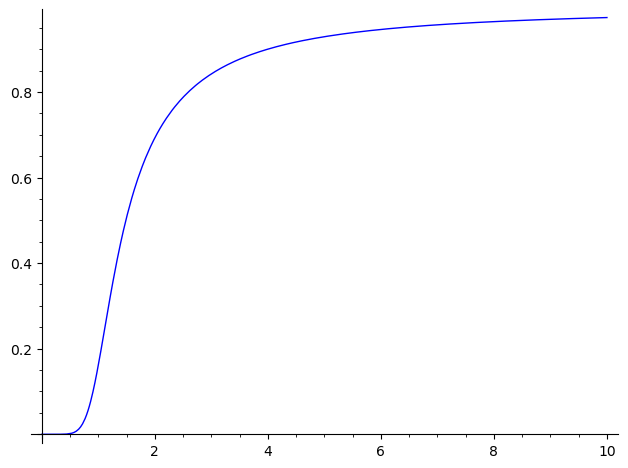

In [136]:
plot(a.subs({r:x}), (x,0,10))